LSTM

In [48]:
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [49]:
acao = 'MGLU3.SA'

ativo = yf.download(acao, period="5y")

[*********************100%***********************]  1 of 1 completed


In [50]:
ativo.head()

Price,Close,High,Low,Open,Volume
Ticker,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA
Date,,,,,
2020-02-20,131.825470,135.532625,130.170086,135.066326,4763914
2020-02-21,131.615662,134.809870,129.167534,129.750422,4099331
2020-02-26,123.292038,126.019948,120.680710,123.711719,5743083
2020-02-27,117.160080,124.504441,116.623824,121.240283,6288606
2020-02-28,117.789597,117.789597,110.095496,114.245649,8424808


In [51]:
# Pega somente o atributo "Close" e armazena em um array bidimensional
#O array precisa ser bidimensional porque o MinMaxScaler espera uma entrada com esse formato.
ativo_close = ativo['Close'].dropna().to_numpy().reshape(-1, 1)

In [52]:
# Criar um DataFrame com os valores ajustados
data = pd.DataFrame(ativo_close)
data.columns = ['Close']

In [53]:
# Normalizar os dados para os modelos
scaler = MinMaxScaler(feature_range=(0, 1))
data['Scaled_Close'] = scaler.fit_transform(data[['Close']])

In [54]:
# Função para criar janelas de dados
# janela de dados = quantidade de dias do X
def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)


In [55]:
window_size = 30
scaled_data = data['Scaled_Close'].values
X, y = create_dataset(scaled_data, window_size)

In [56]:
scaled_data.shape, X.shape, y.shape

((1245,), (1215, 30), (1215,))

In [57]:
# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [58]:
# Ajustar o formato para o LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [59]:
# Criar o modelo LSTM
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.3),
    LSTM(100, return_sequences=True),
    Dropout(0.3),
    LSTM(100),
    Dropout(0.3),
    Dense(1)
])

C:\Users\ramon\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [60]:
# Compilar o modelo
# A função de loss é a forma de medir o erro do modelo, que nesse caso
#é o classico erro médio quadrático da que é usado em regressão linear
#otimizador e medida de erro

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


In [61]:
# Treinar o modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

model.fit(X_train, y_train, 
               epochs=100, 
               batch_size=32, 
               validation_data=(X_test, y_test),
               callbacks=[early_stopping, reduce_lr], 
               verbose=1)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0769 - val_loss: 1.1716e-04 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0063 - val_loss: 3.3414e-05 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0048 - val_loss: 1.0910e-04 - learning_rate: 0.0010
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0039 - val_loss: 3.1120e-05 - learning_rate: 0.0010
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0042 - val_loss: 5.5656e-05 - learning_rate: 0.0010
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0043 - val_loss: 3.0022e-05 - learning_rate: 0.0010
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0030 - val_loss: 5.4032e-05 - learning_rate: 5.0000e-04
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0030 - val_loss: 5.3966e-05 - learning_rate: 5.0000e-04
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0027 - val_loss: 5

In [62]:
# Fazer previsões
lstm_predictions = model.predict(X_test)

# Inverter a normalização
lstm_predictions = scaler.inverse_transform(lstm_predictions)

1/8 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/stepWARNING:tensorflow:5 out of the last 17 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000020075EA89A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [63]:
df_teste = pd.DataFrame({
    "Date": ativo.index[len(X_train) + window_size : len(X_train) + window_size + len(lstm_predictions)],
    "Real": ativo['Close'].iloc[len(X_train) + window_size : len(X_train) + window_size + len(lstm_predictions)].values.flatten(),
    "Previsão": lstm_predictions.flatten()
})

df_teste["Date"] = pd.to_datetime(df_teste["Date"])

df_teste.set_index("Date", inplace=True)

In [64]:
df_teste

,Real,Previsão
Date,,
2024-03-06,20.600000,20.673206
2024-03-07,20.400000,20.746799
2024-03-08,20.500000,20.779964
2024-03-11,20.000000,20.771946
2024-03-12,20.200001,20.723482
...,...,...
2025-02-14,7.380000,6.716659
2025-02-17,7.960000,6.747224
2025-02-18,7.680000,6.781693


In [65]:
# Calcular métricas
mae = mean_absolute_error(df_teste["Real"], df_teste["Previsão"])
mse = mean_squared_error(df_teste["Real"], df_teste["Previsão"])
rmse = np.sqrt(mse)
r2 = r2_score(df_teste["Real"], df_teste["Previsão"])

# Exibir resultados
print(f"📊 MÉTRICAS DE ERRO DO MODELO LSTM 📊")
print(f"MAE  (Erro Absoluto Médio)  : {mae:.4f}")
print(f"MSE  (Erro Quadrático Médio): {mse:.4f}")
print(f"RMSE (Raiz do Erro Médio)   : {rmse:.4f}")
print(f"R²   (Coeficiente de Determinação): {r2:.4f}")


📊 MÉTRICAS DE ERRO DO MODELO LSTM 📊
MAE  (Erro Absoluto Médio)  : 0.8592
MSE  (Erro Quadrático Médio): 1.1479
RMSE (Raiz do Erro Médio)   : 1.0714
R²   (Coeficiente de Determinação): 0.9157


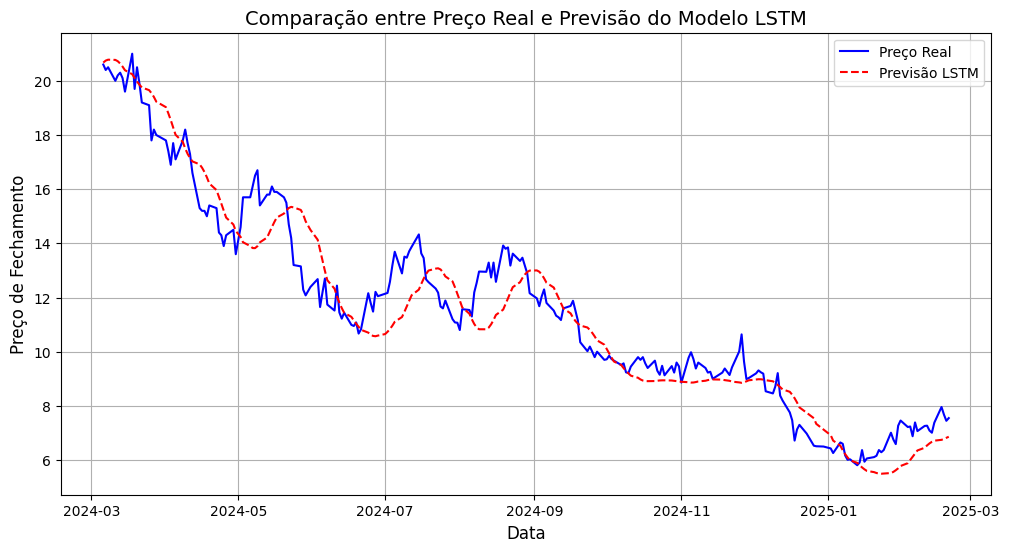

In [66]:
import matplotlib.pyplot as plt

# Criar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_teste.index, df_teste["Real"], label="Preço Real", linestyle="-", color="blue")
plt.plot(df_teste.index, df_teste["Previsão"], label="Previsão LSTM", linestyle="--", color="red")

# Adicionar títulos e legendas
plt.title("Comparação entre Preço Real e Previsão do Modelo LSTM", fontsize=14)
plt.xlabel("Data", fontsize=12)
plt.ylabel("Preço de Fechamento", fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar o gráfico
plt.show()


In [67]:
#calcular media de acertos e expectativa de lucro

#Nova coluna com a variação percentual da ação real
df_teste['Variação percentual real'] = df_teste['Real'].pct_change()

#Nova coluna com a variação percentual da ação prevista
df_teste['Variação percentual previsão'] = df_teste['Previsão'].pct_change()

#Remover valores nulos
df_teste = df_teste.dropna()

#Nova coluna com a informação se a ação subiu ou não
df_teste['Ação subiu'] = np.where(df_teste['Variação percentual real'] > 0, 
                                                      True, False)

#Nova coluna com a informação se a previsão subiu ou não
df_teste['Previsão subiu'] = np.where(df_teste['Variação percentual previsão'] > 0, 
                                                      True, False)

#Nova coluna com a informação se o modelo acertou a tendência
df_teste['Modelo acertou tendência'] = np.where(df_teste['Ação subiu'] == df_teste['Previsão subiu']
                                      , True, False)

#Nova coluna com a variação percentual real absoluta
df_teste['Variação percentual real absoluto'] = df_teste['Variação percentual real'].abs()

C:\Users\ramon\AppData\Local\Temp\ipykernel_11472\1924753693.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste['Ação subiu'] = np.where(df_teste['Variação percentual real'] > 0,
C:\Users\ramon\AppData\Local\Temp\ipykernel_11472\1924753693.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste['Previsão subiu'] = np.where(df_teste['Variação percentual previsão'] > 0,
C:\Users\ramon\AppData\Local\Temp\ipykernel_11472\1924753693.py:21: SettingWithCopyWarning: 
A value is trying to be set on 

In [68]:
#calcular media de acertos e expectativa de lucro
acertou_lado = df_teste['Modelo acertou tendência'].sum()/len(df_teste['Modelo acertou tendência'])

#calcular media de erros e expectativa de lucro
errou_lado = 1 - acertou_lado

#calcular media de lucro agrupado por acertos e erros
media_lucro = df_teste.groupby('Modelo acertou tendência')['Variação percentual real absoluto'].mean()

In [69]:
#calcular media de acertos e expectativa de lucro
acertou_lado = df_teste['Modelo acertou tendência'].sum()/len(df_teste['Modelo acertou tendência'])

#calcular media de erros e expectativa de lucro
errou_lado = 1 - acertou_lado

#calcular media de lucro agrupado por acertos e erros
media_lucro = df_teste.groupby('Modelo acertou tendência')['Variação percentual real absoluto'].mean()

#calcular expectativa matematica de lucro
exp_mat_lucro = acertou_lado * media_lucro[1] - media_lucro[0] * errou_lado

#calcular ganho sobre perda
ganho_sobre_perda = media_lucro[1]/media_lucro[0]

#calcular rendimento diario
exp_mat_lucro_percent = exp_mat_lucro * 100

print(f"Media lucro: {media_lucro}")
print(f"Ganho sobre perda: {ganho_sobre_perda}")
print(f"Acertou lado: {acertou_lado}")
print("rendimento diário: " + str(round(exp_mat_lucro_percent, 4)) + "%")


Media lucro: Modelo acertou tendência
False    0.033330
True     0.030027
Name: Variação percentual real absoluto, dtype: float64
Ganho sobre perda: 0.9009223105418812
Acertou lado: 0.5454545454545454
rendimento diário: 0.1229%


C:\Users\ramon\AppData\Local\Temp\ipykernel_11472\2764833411.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  exp_mat_lucro = acertou_lado * media_lucro[1] - media_lucro[0] * errou_lado
C:\Users\ramon\AppData\Local\Temp\ipykernel_11472\2764833411.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ganho_sobre_perda = media_lucro[1]/media_lucro[0]


In [70]:
data_hoje = datetime.datetime.now()

#verifica se a hora é maior que 18:00
if data_hoje.hour > 18:
    print("Mercado fechado")

AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

In [ ]:
data_hoje = datetime.now()

data_inicio_modelo = ativo.index[0]

if data_hoje.hour > 18:
    final = data_hoje
    inicial = datetime.now() - timedelta(days = 252)
    print("Preço de fechamento amanhã: \n")
    
else:
    final = data_hoje - timedelta(days = 1)
    inicial = datetime.now() - timedelta(days = 252)
    print("Preço de fechamento hoje: \n")
    
cotacoes = yf.download(acao, start=inicial, end=final)

ultimos_60_dias = cotacoes['Close'].iloc[-60:].values.reshape(-1, 1)

ultimos_60_dias_escalado = scaler.transform(ultimos_60_dias)

teste_x = []
teste_x.append(ultimos_60_dias_escalado)
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

previsao_de_preco = model.predict(teste_x)
previsao_de_preco   = scaler.inverse_transform(previsao_de_preco)

print(previsao_de_preco[0][0])

Preço de fechamento hoje: 



[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
7.2214065



C:\Users\ramon\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
